# Plan 

Add bits of a4-FIER_LOOP to this notebook to make the flood forecasting notebook. 

<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />

<br>
<font size="6"> <b>FIER Daily Flood Forecasting Code</b><img style="padding: 7px" src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/UAFLogo_A_647.png" width="170" align="right"/></font>

<br>
<font size="4"> <b> Franz J Meyer, University of Alaska Fairbanks</b> <br>
</font>

This notebooks is developing an algorithm to generate daily flood inundation predictions using time series of Sentinel-1 RTC data and GEOGLoWs river runoff forecasts. 
    
The workflow utilizes information available in the fierpy <a href="https://github.com/SERVIR/fierpy">fierpy</a> GitHub repository.
<hr>


# Load Python Libraries

In [1]:
# installs to make Victor's code work
# These only need to be installed once. 
# !pip install --quiet xeofs
# !python -m pip install "tensorflow==2.17.0"

In [2]:
import xeofs as xe
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import glob
import re
import rioxarray as rxr
import rasterio
from pyproj import Transformer
import time
from collections import Counter
from fier_new_geoglows import get_streamflow as g_sf_new
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Normalization

print(tf.__version__)
from fier_local import *

2.17.0


## CREATE FUNCTIONS

In [3]:
### --- Get Dates from filenames --- ###
def get_dates(dir_path, prefix):
    dates = []
    pths = list(dir_path.glob(f'{prefix}.tif*'))

    for p in pths:
        date_regex = '\d{8}'
        date = re.search(date_regex, str(p))
        if date:
            dates.append(date.group(0))
    return dates





### --- Load Geotiffs Function --- ###
def load_tiffs(parent, type_file, pola, stop_ind = -1):

    # Load the appropriate files
    if type_file == 'SAR':
        folder = parent+'RTC_GAMMA/'
        prefix = f'*{pola}'
    else:
        folder = parent+'Water_Masks/'
        prefix = '*combined'

    # Gather names of files corresponding to the file type and polarization we want
    tiff_dir = Path(folder)
    tiffs = list(tiff_dir.glob(f'{prefix}.tif*'))
    
    # Gather the date of each file
    times = get_dates(tiff_dir, prefix)
    
    # Create a list of indices based on the sorted order of times
    sorted_indices = sorted(range(len(times)), key=lambda i: times[i])
    
    # Sort the paths based on the times
    tiffs = [tiffs[i] for i in sorted_indices]
    
    # Sort the times axisdd
    times.sort()
    times = pd.DatetimeIndex(times)
    times.name = "time"
    
    # Create the dataset gathering the input images
    da = xr.concat([rxr.open_rasterio(f).squeeze(dim='band') for f in tiffs[:stop_ind]], dim=times[:stop_ind])
    da = da.drop_vars(['band', 'spatial_ref'])

    print(f"Dataset size in memory: {da.nbytes / 1e6:.2f} MB")

    return da, tiffs, times

 



### --- Get boundary coordinates of geotiff --- ###       
def get_coordinates_from_geotiff_bbox(geotiff_path):
    dataset = gdal.Open(geotiff_path)

    # Get the GeoTransform to convert pixel coordinates to geographical coordinates
    transform = dataset.GetGeoTransform()

    # Get the raster size (number of rows and columns)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize

    # Get the four corner points in pixel coordinates
    corners = [(0, 0), (cols, 0), (cols, rows), (0, rows)]

    # Calculate the longitude (X) and latitude (Y) of each corner
    corner_coordinates = []
    for corner in corners:
        lon = transform[0] + corner[0] * transform[1] + corner[1] * transform[2]
        lat = transform[3] + corner[0] * transform[4] + corner[1] * transform[5]

        # Get the spatial reference system of the dataset
        srs = osr.SpatialReference()
        srs.ImportFromWkt(dataset.GetProjection())

        # Create a coordinate transformation object
        target_srs = osr.SpatialReference()
        target_srs.ImportFromEPSG(4326)  # EPSG code for WGS84
        transform_obj = osr.CoordinateTransformation(srs, target_srs)

        # Transform the coordinates to WGS84 (latitude and longitude)
        lon, lat, _ = transform_obj.TransformPoint(lon, lat)

        corner_coordinates.append((lat, lon))
        
    corner_coordinates = np.array(corner_coordinates)
    boundaries = np.array([[np.min(corner_coordinates[:,1]), np.min(corner_coordinates[:,0])],
                           [np.max(corner_coordinates[:,1]), np.max(corner_coordinates[:,0])]])

    return boundaries





### --- Get center coordinates of geotiff --- ###
def get_centerpoint_coordinates(tif_file):
    # Open the raster file
    with rasterio.open(tif_file) as dataset:
        # Get the CRS of the raster
        crs = dataset.crs
    
        # Get the bounds of the raster (left, bottom, right, top)
        bounds = dataset.bounds
    
        # Calculate the center point in the raster's CRS
        center_x = (bounds.left + bounds.right) / 2
        center_y = (bounds.bottom + bounds.top) / 2
    
        # Initialize the transformer to convert from the raster's CRS to EPSG:4326
        transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    
        # Transform the center point coordinates to EPSG:4326
        center_lon, center_lat = transformer.transform(center_x, center_y)
    
        print(f"Center Longitude: {center_lon}, Center Latitude: {center_lat}")

        return center_lat, center_lon





### --- REOF Analysis of dataset --- ###
def reof(da, n_modes, rtol):

    start_time = time.time()
    model = xe.single.EOF(n_modes=n_modes, standardize=True, use_coslat=False)
    model.fit(da, dim="time")
    # (2) Varimax-rotated EOF analysis
    rot_var = xe.single.EOFRotator(n_modes=n_modes, power=1, rtol = rtol)
    rot_var.fit(model)
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio() * 100
    pcs = rot_var.scores()
    modes = rot_var.components()    

    # End time
    end_time = time.time()
    
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"REOF time: {elapsed_time:.2f} seconds")

    # Rename the DataArrays
    spatial_modes = modes.rename('spatial_modes')
    temporal_modes = pcs.rename('temporal_modes')
    
    # Flatten data from [t, y, x] to [t, space]
    da_flat = da.stack(space=('y', 'x'))
    
    # Compute the temporal mean for each pixel and reshape
    center = da_flat.mean(dim='time').unstack('space')
    
    # Create a DataArray for 'center' with 'y' and 'x'
    center = xr.DataArray(center, dims=['y', 'x'], coords={'y': modes.y, 'x': modes.x}, name='center')
    
    # Merge into a single dataset
    reof_ds = xr.Dataset({'spatial_modes': spatial_modes, 'temporal_modes': temporal_modes, 'center': center})

    return reof_ds 





# --- Polynomial fits of modes for discharge --- ###
def best_polynomial_fits(reof_ds, max_deg, NSE_cut):

    # Generate list of degrees from 1 to max_deg
    degrees = np.arange(1, max_deg+1)

    # Initialize storage lists
    tot_score = []
    tot_mode = []
    tot_deg = []
    tot_poly = []

    # For each mode, for each degree, iterate 10 times through random 70% of entries to find a score that passes the NSE
    for nb_mod in reof_ds.mode.values:

            # Initialize storage lists
            best_score_list = []
            best_mode_list = []
            best_poly_list = []
            best_deg_list = []

            # Iterate through every degree
            for deg in degrees:

                # Initialize the scores
                score = 0
                best_deg = 0
                best_mode = 0
                best_poly = 0

                # Run 10 times for each degree, 50% of the entries are randomly selected for training
                for iterator in range(10):

                    # Generate all indices
                    all_indices = np.arange(len(reof_ds.time))
                    
                    # Shuffle the indices
                    np.random.shuffle(all_indices)
                    
                    # Determine the split point
                    split_point = int(len(reof_ds.time) * 0.5)  # 70% for training
                    
                    # Create training and test indices
                    inds_train = all_indices[:split_point]
                    inds_test = all_indices[split_point:]

                    # Create the polynomial fit
                    f = np.poly1d(np.polyfit(q[inds_train],reof_ds.temporal_modes.sel(mode=nb_mod)[inds_train],deg=deg))
                    
                    # Predict the values
                    y_pred = f(q[inds_test])

                    # Get the true values
                    Y = reof_ds.temporal_modes.sel(mode=nb_mod)[inds_test]

                    # Calculate NSE. If it passes then the score is compared to the previous best score.
                    nse = 1 - ( (np.nansum(np.square( Y - y_pred ))) / (np.nansum(np.square( Y - np.nanmean(Y) ))) )
                    if nse >= NSE_cut:
                        if nse >= score:
                            score = nse
                            best_deg = deg
                            best_mode = nb_mod
                            best_poly = f.coeffs
                
                # Print the scores that passed the NSE are have the best score
                if score >= NSE_cut:
                    print(f"Mode {nb_mod} - Degree {deg} - NSE {score}")

                # Append the arrays with the best score
                best_score_list.append(score)
                best_deg_list.append(best_deg)
                best_mode_list.append(best_mode)
                best_poly_list.append(best_poly)
            
            # Store best indices passing the NSE
            indmax = np.argmax(best_score_list)
            tot_score.append(best_score_list[indmax])
            tot_deg.append(best_deg_list[indmax])
            tot_mode.append(best_mode_list[indmax])
            tot_poly.append(best_poly_list[indmax])

    # Get 1 entry per mode
    ind_valid = list(np.where(np.array(tot_score)>NSE_cut)[0])
    final_mode = [tot_mode[i] for i in ind_valid]
    temp_f = [tot_poly[i] for i in ind_valid]
    final_deg = [tot_deg[i] for i in ind_valid]
    final_f = []
    inds_final_pass = []

    for ind in range(len(final_mode)):
    
        # Plot the best combination
        f = np.poly1d(temp_f[ind])
        final_f.append(f)
        Y = reof_ds.temporal_modes.sel(mode=final_mode[ind])
        Y_mdl = f(q.values)
        
        # Calculate NSE one more time with all the data
        nse = 1 - ( (np.nansum(np.square( Y - Y_mdl ))) / (np.nansum(np.square( Y - np.nanmean(Y) ))) )

        # Plot if NSE passes
        if nse >= NSE_cut:
            plt.figure()
            plt.scatter(q,reof_ds.temporal_modes.sel(mode=final_mode[ind]), label='original data')
            plt.plot(np.sort(q), f(np.sort(q)), color = 'red', label = 'polyfit')
            plt.legend()
            # Calculate plot limits
            xlim = plt.xlim()
            ylim = plt.ylim()
            
            # Add text with coordinates relative to the plot limits
            plt.text(
                xlim[0] + 0.8 * (xlim[1] - xlim[0]),  # x-coordinate
                ylim[0] + 0.5 * (ylim[1] - ylim[0]),  # y-coordinate
                'NSE: ' + "{:.2f}".format(nse),
                fontsize=12, color='black'
            )
        
        # Store the indices not passing
        else:
            inds_final_pass.append(ind)
        
    # Remove indices flagged as not passing NSE
    final_f = [item for idx, item in enumerate(final_f) if idx not in inds_final_pass]
    final_deg = [item for idx, item in enumerate(final_deg) if idx not in inds_final_pass]
    final_mode = [item for idx, item in enumerate(final_mode) if idx not in inds_final_pass]

    
    return (final_mode, final_deg, final_f)




### --- Neural Network Initialization --- ###
# ----- Define a callback function, setting up criteria for training to stop -----
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000001, patience=10)


# ----- Declare Tensorflow normalizer of data -----
# -- Initialize normalization process (which axis to be along with, and the shape of input) --
# -- "input_shape=(1,)" means only one variable is used as input. 
#    Since the number of observations in a variable can be dynamic, it often remains unprovided, hence defined as (1,)
#    
#    In the case of multivariate regression, says N variables, are used as input, it becomes
#    "input_shape=(N,)"
#    
#    "axis=-1", means the mean and STD calculated in ".adapt(DATA)" is along the last dimension, which in
#    this case is along column. It depends on which axis of data represent the variable types.
normalizer = Normalization(input_shape=(1,),axis=-1) 


### --- Design Tensorflow model structure --- ###
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        #layers.Dense(128, activation='relu'),
        #layers.Dense(64, activation='relu'),
        layers.Dense(1)               
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam())#tf.keras.optimizers.Adam(0.001))
    return model# ----- Function for plotting training progress -----





### --- Function for plotting training progress ---###
def plot_loss(history):

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')  
    plt.xlabel('Epoch')
    plt.ylabel('[Loss] MSE: RTPC')
    #plt.legend()
    plt.text(0.6,0.7,'Final loss: '+"{:.2f}".format(history.history['loss'][-1]),transform=ax.transAxes)
    plt.grid(True)
    plt.savefig('train_loss.png', dpi=300, bbox_inches='tight')    
    plt.show()





### --- Calculate Neural Network fit for modes --- ###
def nn_fit(reof_ds, q, NSE_cut):
    indx_qual_mode = []
    best_model = []
    best_score = []
    best_nse = 0

    # ----- Train Tensorflow Hydro-to-TPC models mode-by-mode -----
    for mode in reof_ds.mode.values:  
        keras.backend.clear_session()    
        print('Building models for mode-'+str(mode).zfill(2))
        tpc = reof_ds.temporal_modes.sel(mode=int(mode))        

        X = q.values.reshape(len(q),1)
        Y = tpc.values.reshape(len(q),1)
    
        X_train = X
        Y_train = Y     
    
        # -- adapt function is to get the mean and STD used to normalize the input data of the model --
        normalizer.adapt(X_train)    
    
        # ----- Construct the model and get summary -----
        model = build_and_compile_model(normalizer)
        #if vis_tf_nn==0:
        #elif vis_tf_nn==1:
        #  plot_model(model, to_file='NOAA_WF\\hydro2rtpc_mdl\\'+data_src+'\\site-'+str(gaugeID_list[site])+'_tpc'+str(mode+1).zfill(2)+'.png', show_shapes=True, show_layer_names=True)
    
         # ----- Fit the model -----
        train_proc = model.fit(
            X_train, 
            Y_train, 
            callbacks=[callback],
            batch_size=32, 
            epochs=100, 
            verbose=0, 
            #validation_split=0.2
        )    

        # ----- Plot model estimation and original scatter plot -----
        X_sim = tf.linspace(np.amin(X), np.amax(X), X.size*10^10)
        Y_sim = model.predict(X_sim)
   

        # ----- The second-time REOF mode screening based on quality of regression models. If qualified, export trained model -----
        Y_mdl = model.predict(X[:,0])
        nse = 1 - ( (np.nansum(np.square( Y - Y_mdl ))) / (np.nansum(np.square( Y - np.nanmean(Y) ))) )

        if nse >= NSE_cut: # Moriasi et al., 2007. Consider NSE>0.5 as satisfactory
            
            model.summary()
            print(mode, nse)

            # ----- Plot training progress -----  
            plot_loss(train_proc)

            best_nse = nse
            best_score.append(best_nse)
            best_model.append(model)
            indx_qual_mode.append(mode)

            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            plt.scatter(X, Y)
            plt.plot(X_sim, Y_sim, color='r')
            plt.xlabel('discharge (m3/d)')
            plt.ylabel(f"mode {mode}")  
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=45)
            plt.legend(['NN-Model','Data'],loc='upper left')
            plt.text(0.2,0.5,'NSE: '+"{:.2f}".format(nse), transform=ax.transAxes)
            plt.savefig('test.png', dpi=300, bbox_inches='tight')
            plt.show()
    
            # ----- Export trained model -----
            #best_model.save('test.keras')  
            
    return(best_model, indx_qual_mode)





### --- Z-Score calculation --- ###
def z_score(flood_forecast, flood_hindcast):
    # Calculate the indices for scoring: a = true positive, b = false positive, c = false negative, d = true negative
    a = np.sum(np.logical_and(flood_forecast == 1, flood_hindcast == 1))
    b = np.sum(np.logical_and(flood_forecast == 1, flood_hindcast == 0))
    c = np.sum(np.logical_and(flood_forecast == 0, flood_hindcast == 1))
    d = np.sum(np.logical_and(flood_forecast == 0, flood_hindcast == 0))

    # Calculate the skills
    overall_accuracy = ((a + b) / (a + b + c + d)) * 100
    CSI = (a / (a + b + c)) * 100
    precision = (a / (a + b)) * 100
    recall = (a / (a + c)) * 100
    
    # Replace NaNs by 0s
    if np.isnan(overall_accuracy):
        overall_accuracy = 0
    if np.isnan(CSI):
        CSI = 0
    if np.isnan(precision):
        precision = 0
    if np.isnan(recall):
        recall = 0

    return overall_accuracy, CSI, precision, recall
    

<>:7: SyntaxWarning:

invalid escape sequence '\d'

<>:7: SyntaxWarning:

invalid escape sequence '\d'

/tmp/ipykernel_335/1725778298.py:7: SyntaxWarning:

invalid escape sequence '\d'

/home/jovyan/.local/envs/fierpy/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



## SELECT DATA FOLDER

In [4]:
from ipyfilechooser import FileChooser
fc = FileChooser(Path.cwd())
display(fc)

FileChooser(path='/home/jovyan/hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [5]:
fc.selected

'/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/'

***
## LOAD DATA

Select the input file type: water masks ('Water_Masks') or SAR imagery ('SAR')

In [6]:
# Input type of file: 'Water_Masks' or 'SAR
type_file = 'Water_Masks'

# Input type of polarization for SAR: 'VV' or 'VH'
if type_file == 'SAR':
    pola = 'VV'
else:
    pola = 'combined'
import time

## Load data for plotting and later input into the REOF. 

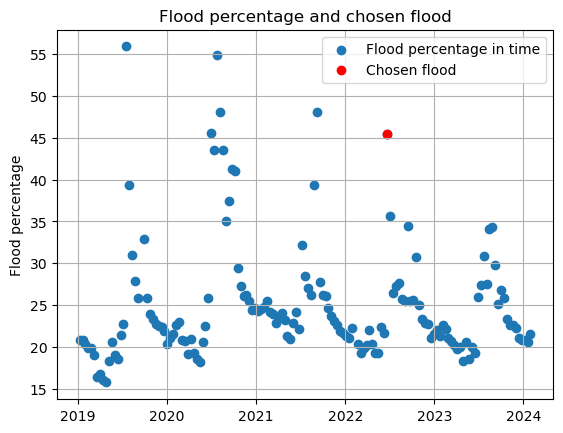

In [7]:
# Import flood percentage calculation from water masks
floodpercent = np.load(fc.selected+"Figures/flood_percentage.npy")

# Import time associated with the floods
time_flood = np.load(fc.selected+"Figures/time_index.npy")

### --- Choose an index that represents a flood --- ###
ind_flood = 103

# Plot the flood percentage and index chosen
fig_flood = plt.figure()
plt.scatter(time_flood, floodpercent, label = 'Flood percentage in time')
plt.scatter(time_flood[ind_flood],floodpercent[ind_flood],color='red', label = 'Chosen flood')
plt.title('Flood percentage and chosen flood')
plt.ylabel('Flood percentage')
plt.grid()
plt.legend()

plt.show()

In [8]:
# Load tiffs
da_tot, tiffs_tot, times_tot = load_tiffs(fc.selected, type_file, pola, stop_ind = -1)

# Check match between selected date of flood and tiffs
if da_tot.time[ind_flood].values == time_flood[ind_flood]:
    print('Dates of floods and tiffs are matching')
else:
    print('Dates of floods and tiffs are not matching')

# Grab lat/lon of tiffs to get discharge forecast
lat, lon = get_centerpoint_coordinates(tiffs_tot[0])

print(lat, lon)

Dataset size in memory: 716.88 MB
Dates of floods and tiffs are matching
Center Longitude: 89.77166694876536, Center Latitude: 24.46737933371171
24.46737933371171 89.77166694876536


In [9]:
# Get discharge forecast
print('Getting streamflow data.')
# q_tot, ID = get_streamflow(lat, lon)
q_tot, ID = g_sf_new(lat,lon)
print('Streamflow data acquired.')

Getting streamflow data.
Streamflow data acquired.


### Plot flood and discharge data over full time series

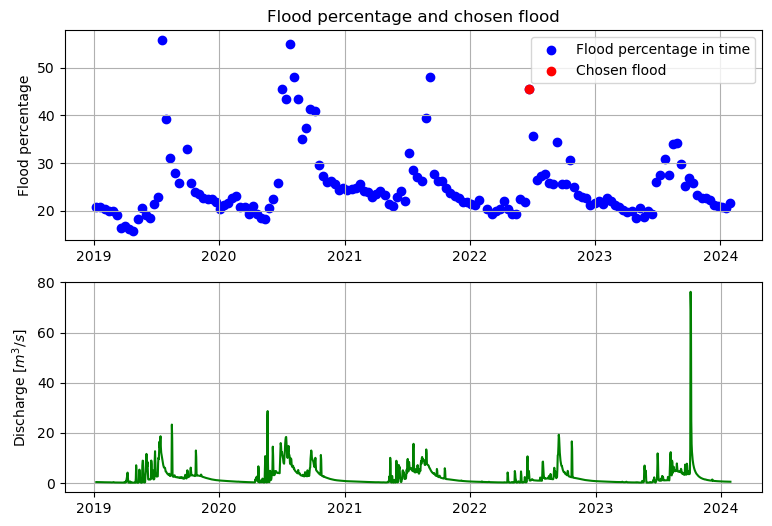

In [10]:


# Plot the flood percentage and index chosen
fig_fNd = plt.figure(figsize=(9,6))
ax_flood = plt.subplot(2,1,1)
ax_disch = plt.subplot(2,1,2)
ax_flood.scatter(time_flood, floodpercent, color='blue', label = 'Flood percentage in time')
ax_flood.scatter(time_flood[ind_flood],floodpercent[ind_flood],color='red', label = 'Chosen flood')
ax_flood.set_title('Flood percentage and chosen flood')
ax_flood.set_ylabel('Flood percentage')
ax_flood.grid()
ax_flood.legend()



# get matching date for dischage and images/masks
idxA, idxB = np.where(times_tot[0] == q_tot.time)[0][0], np.where(times_tot[-1] == q_tot.time)[0][0]

# plot discharge
ax_disch.plot(q_tot[idxA:idxB].time,q_tot[idxA:idxB], color='green', label='Discharge')
ax_disch.set_ylabel('Discharge [$m^3/s$]')
ax_disch.grid()

plt.show()

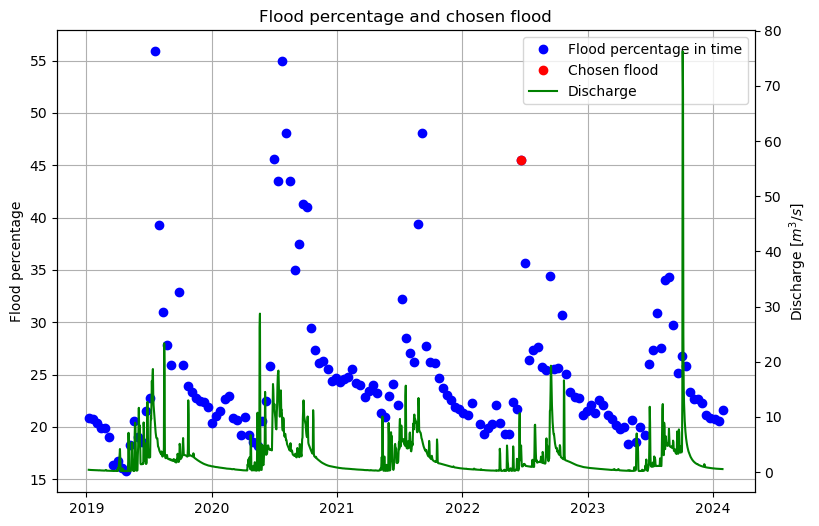

In [11]:


fig_fNd, ax_flood = plt.subplots(figsize=(9,6))
# Plot the flood percentage and index chosen
lns1 = ax_flood.plot(time_flood, floodpercent, color='blue', linestyle= 'None', marker='o', label = 'Flood percentage in time')
lns2 = ax_flood.plot(time_flood[ind_flood],floodpercent[ind_flood],color='red', linestyle= 'None', marker='o', label = 'Chosen flood')

ax_disch = ax_flood.twinx() # twin the axis so both can be on the same plot. 
# get matching date for dischage and images/masks
idxA, idxB = np.where(times_tot[0] == q_tot.time)[0][0], np.where(times_tot[-1] == q_tot.time)[0][0]
lns3 = ax_disch.plot(q_tot[idxA:idxB].time,q_tot[idxA:idxB], color='green', label='Discharge')

# set axis
ax_flood.set_title('Flood percentage and chosen flood')
ax_flood.set_ylabel('Flood percentage')
ax_disch.set_ylabel('Discharge [$m^3/s$]')
ax_flood.grid()

# combine the line labels into one for the legend. 
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax_flood.legend(lns, labs)

plt.show()

### Plot imagery (water masks or SAR based on earlier selection) of pre- and during flooding, their difference, and the relevant discharge data over that time. 

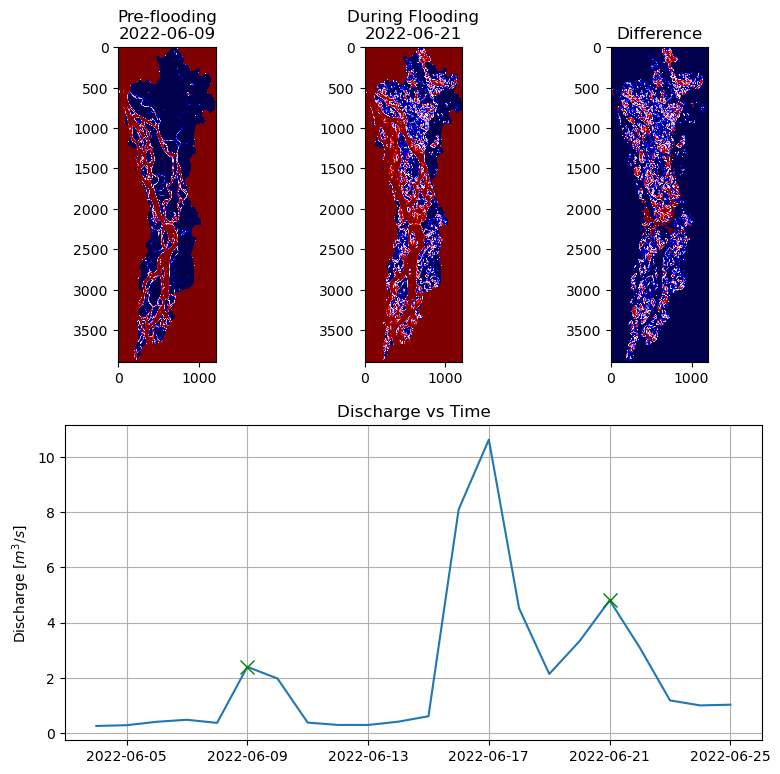

In [12]:
# get matching date for discharge and images/masks
idx1, idx2 = np.where(da_tot[ind_flood-1].time == q_tot.time)[0][0], np.where(da_tot[ind_flood].time == q_tot.time)[0][0]


# plot of pre (ind_flood-1) and during (ind_flood) flooding from water_masks/SAR images. 
fig_flooding = plt.figure(figsize=(9,9))
ax_pre = plt.subplot(2,3,1)
ax_during = plt.subplot(2,3,2)
ax_diff = plt.subplot(2,3,3)
if type_file == 'Water_Masks':
    vmin, vmax = 0, 1
elif type_file == 'SAR':
    vmin, vmax = 0, 255
ax_pre.imshow(da_tot[ind_flood-1], vmin=vmin, vmax=vmax, cmap='seismic', interpolation=None) 
ax_during.imshow(da_tot[ind_flood], vmin=vmin, vmax=vmax, cmap='seismic', interpolation=None)
da_diff = da_tot[ind_flood] - da_tot[ind_flood-1]
ax_diff.imshow(da_diff, vmin=vmin, vmax=vmax, cmap='seismic', interpolation=None)
ax_pre.title.set_text(f'Pre-flooding\n{q_tot[idx1].time.dt.strftime("%Y-%m-%d").values}')
ax_during.title.set_text(f'During Flooding\n{q_tot[idx2].time.dt.strftime("%Y-%m-%d").values}')
ax_diff.title.set_text('Difference')
                                       
# plot of discharge through time
ax_dis = plt.subplot(2,1,2)
xtra = 5
ax_dis.plot(q_tot[idx1-xtra:idx2+xtra].time,q_tot[idx1-xtra:idx2+xtra])
# ax_dis.plot(q_tot[idx1-1000:idx2+xtra].time,q_tot[idx1-1000:idx2+xtra])
ax_dis.plot(q_tot[idx1].time, q_tot[idx1], color='green', marker='x', markersize=10)
ax_dis.plot(q_tot[idx2].time, q_tot[idx2], color='green', marker='x', markersize=10)
ax_dis.grid()
ax_dis.title.set_text('Discharge vs Time')
ax_dis.set_ylabel('Discharge [$m^3/s$]')

plt.show()

## Calculate REOF

### Filter data to relevant times for the REOF

In [13]:
# Crop tiffs and dates to the dates of interest, keep the rest
da = da_tot[:ind_flood]
tiffs = tiffs_tot[:ind_flood]
times = times_tot[:ind_flood]

# Crop to date range
q = match_dates(q_tot, da.time)

### Run the REOF

In [14]:
# Calculate REOF of the tiffs
myTolerance = 1e-4
reof_ds = reof(da, 10, myTolerance)

REOF time: 94.02 seconds


### Visualize the temporal modes

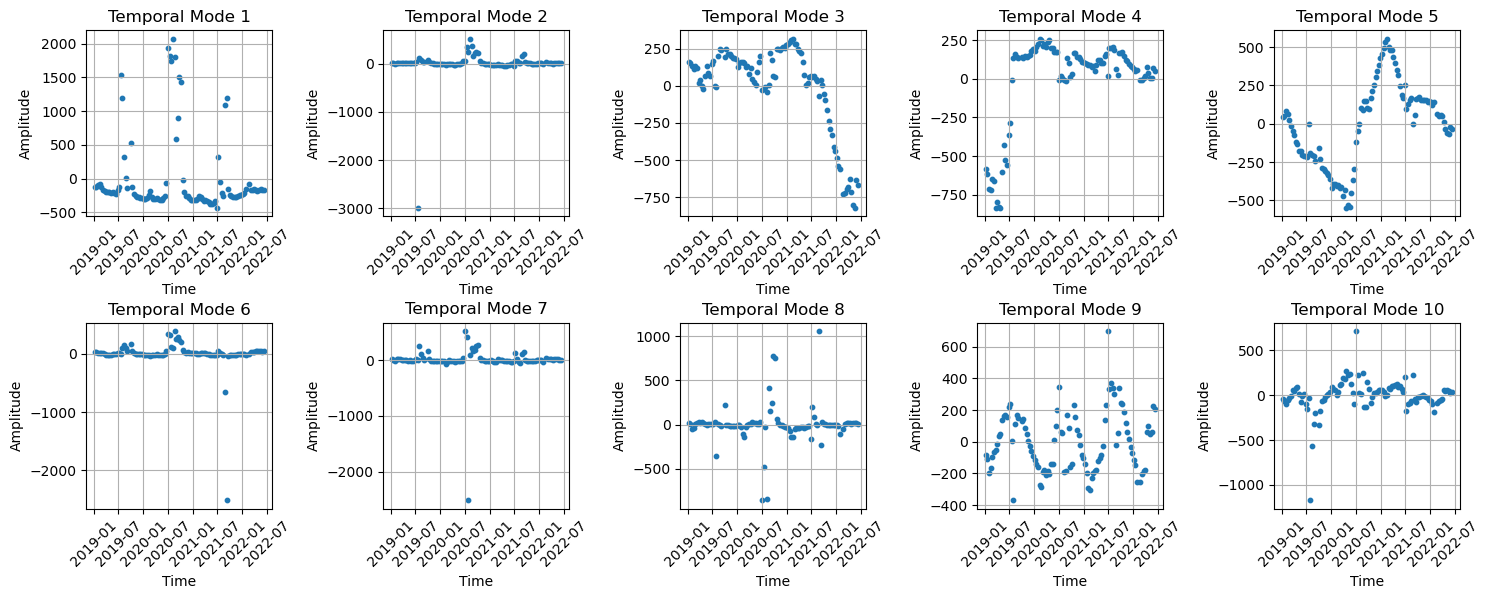

In [15]:
# Number of temporal modes to plot
num_modes = 10

# Create subplots: 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the first 10 modes and plot
for i in range(num_modes):
    ax = axes[i]
    ax.scatter(reof_ds.time, reof_ds.temporal_modes[i], label=f'Mode {i+1}', s=10)
    ax.set_title(f'Temporal Mode {i+1}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.grid()
    ax.set_box_aspect(1)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

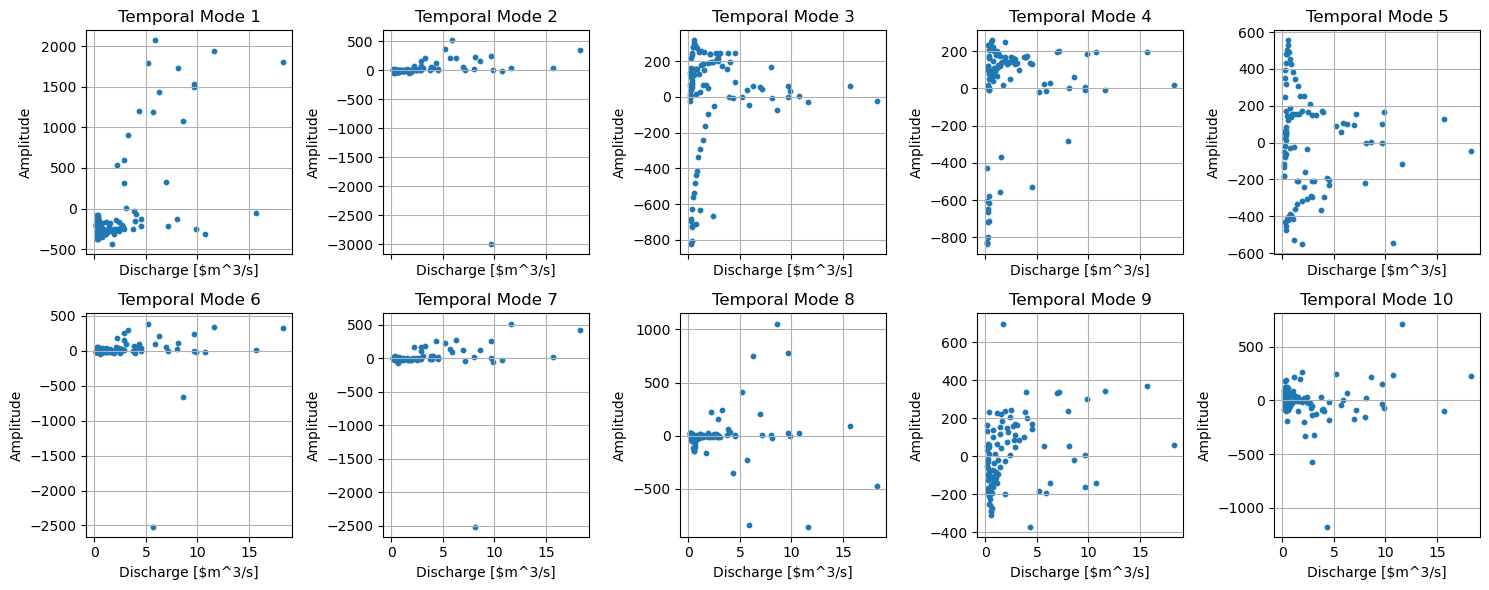

In [16]:
# Number of temporal modes to plot
num_modes = 10

# Create subplots: 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the first 10 modes and plot
for i in range(num_modes):
    ax = axes[i]
    ax.scatter(q.values, reof_ds.temporal_modes[i], label=f'Mode {i+1}', s=10)
    ax.set_title(f'Temporal Mode {i+1}')
    ax.set_xlabel('Discharge [$m^3/s]')
    ax.set_ylabel('Amplitude')
    ax.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Visualize Spatial Modes

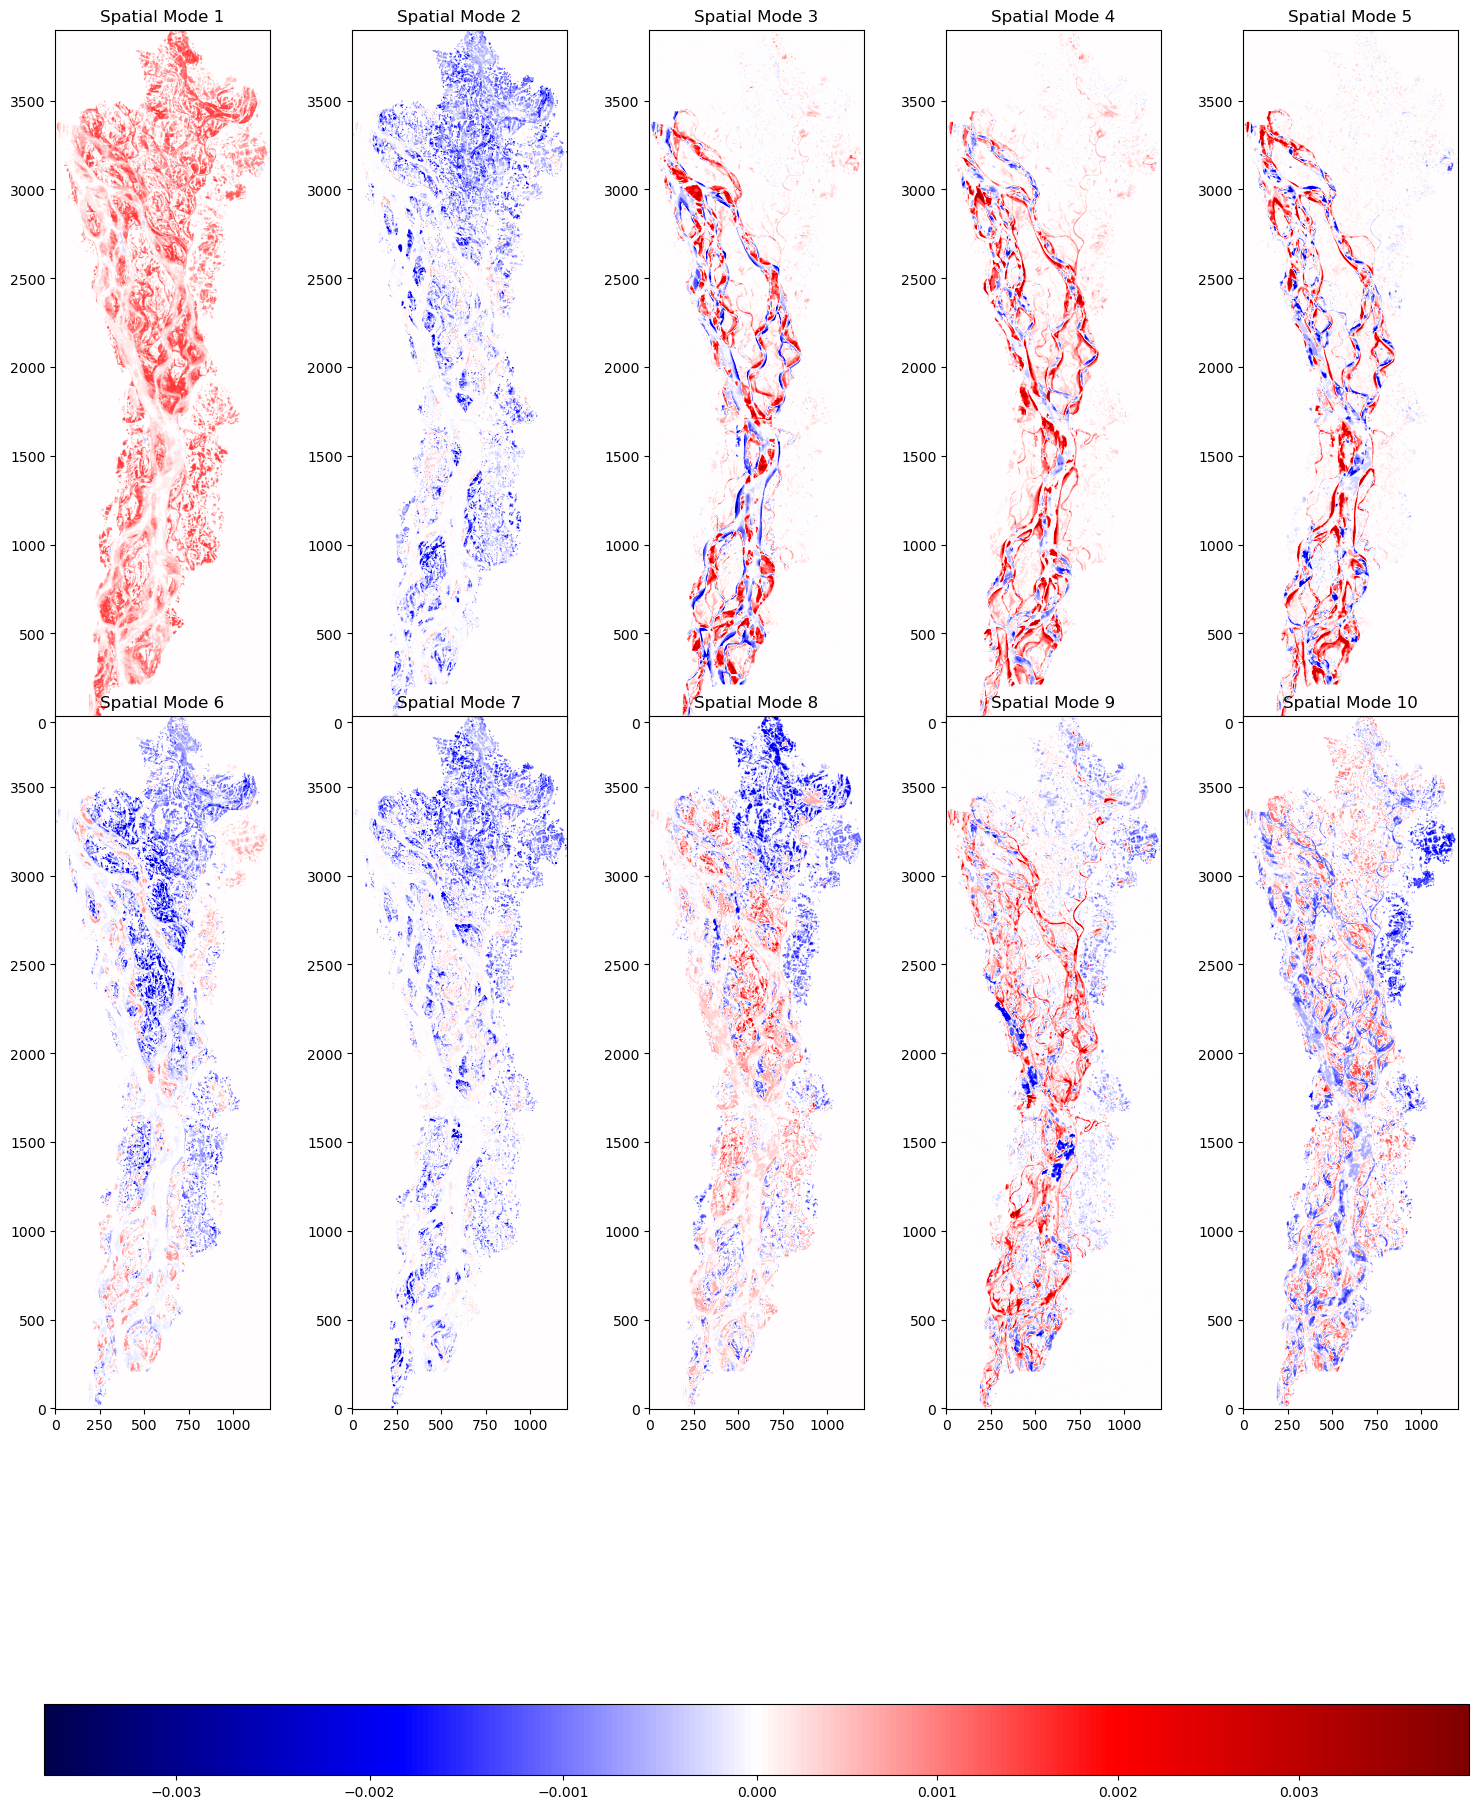

In [17]:
import matplotlib.colors as colors

# Number of temporal modes to plot
num_modes = 10

# Create subplots: 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 20), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

cb_min, cb_max = np.amin(reof_ds.spatial_modes.values), np.amax(reof_ds.spatial_modes.values)

# Loop through the first 10 modes and plot
for i in range(num_modes):
    ax = axes[i]
    spatial_mode = reof_ds.spatial_modes.values[i,:,:]
    norm = colors.TwoSlopeNorm(vmin=cb_min, vcenter = 0, vmax=cb_max)
    im = ax.imshow(spatial_mode, label=f'Mode {i+1}', cmap='seismic', norm=norm, origin='lower')
    ax.set_title(f'Spatial Mode {i+1}')

# create horizontal colorbar


# Adjust layout and show the plot
plt.tight_layout()
fig.colorbar(im, ax=axes, location='bottom', orientation='horizontal')
plt.show()

In [18]:
# double checking that the displayed modes actually match the displayed color bar. 
for i in range(num_modes): 
    spatial_mode = reof_ds.spatial_modes.values[i,:,:]
    print(f'mode = {i+1}, min% = {np.amin(spatial_mode)/cb_min*100.0}, max% = {np.amax(spatial_mode)/cb_max*100.0}')
    print(f'mode = {i+1}, median_neg% = {np.median(spatial_mode[spatial_mode < 0.0])/cb_min*100.0}, median_pos% = {np.median(spatial_mode[spatial_mode>0.0])/cb_max*100.0}\n')
    

mode = 1, min% = 18.239999608340934, max% = 40.97548378107588
mode = 1, median_neg% = 2.8426969418502956, median_pos% = 15.912378702338504

mode = 2, min% = 84.3931390369115, max% = 78.82524433903735
mode = 2, median_neg% = 6.468525004261452, median_pos% = 1.8305554181360058

mode = 3, min% = 84.86450583281163, max% = 79.31544052747257
mode = 3, median_neg% = 2.1194187273985574, median_pos% = 7.1890990543162365

mode = 4, min% = 75.06539258185681, max% = 84.76618688180399
mode = 4, median_neg% = 3.796794427991892, median_pos% = 6.029852527652961

mode = 5, min% = 74.3383254900961, max% = 77.19418733460542
mode = 5, median_neg% = 4.6655319094303405, median_pos% = 4.695416315967955

mode = 6, min% = 92.4652438136388, max% = 86.36478651766807
mode = 6, median_neg% = 4.7120269188497526, median_pos% = 3.9430584098697237

mode = 7, min% = 96.5650611573156, max% = 90.19411562603787
mode = 7, median_neg% = 9.786601530388637, median_pos% = 2.160822388525179

mode = 8, min% = 76.78094451708843, 

## Find best fits polynomial and NN

- Choose the maximum amount of polynomial degrees to evaluate for the fit
- Choose the NSE-score cutoff used to keep polynomial fits as valuable

Mode 1 - Degree 1 - NSE 0.46898338695104147
Mode 1 - Degree 2 - NSE 0.42667340720997304
Mode 1 - Degree 3 - NSE 0.37402988065263676
Mode 1 - Degree 4 - NSE 0.47367012174882217
Mode 1 - Degree 5 - NSE 0.5517857142322615
Mode 4 - Degree 3 - NSE 0.15571627575038516
Mode 4 - Degree 4 - NSE 0.18148736181187886
Mode 4 - Degree 5 - NSE 0.25556284627368064
Mode 8 - Degree 2 - NSE 0.11267737705125536
Mode 9 - Degree 1 - NSE 0.1379282989502274
Mode 9 - Degree 2 - NSE 0.150459375122297
Mode 9 - Degree 3 - NSE 0.21270590108683773
Mode 9 - Degree 4 - NSE 0.11305884756207096
Mode 9 - Degree 5 - NSE 0.2465051172538758
Mode 10 - Degree 3 - NSE 0.14934325023582284
Mode 10 - Degree 5 - NSE 0.13975510046677242
[1, 4, 9, 10]
Polynomial fits found for modes: [1, 4, 9, 10], degrees: [5, 5, 5, 3]


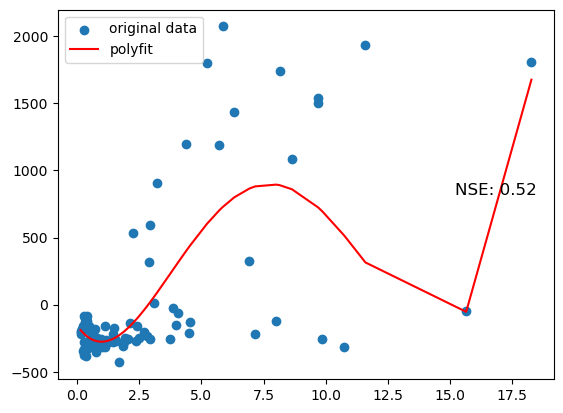

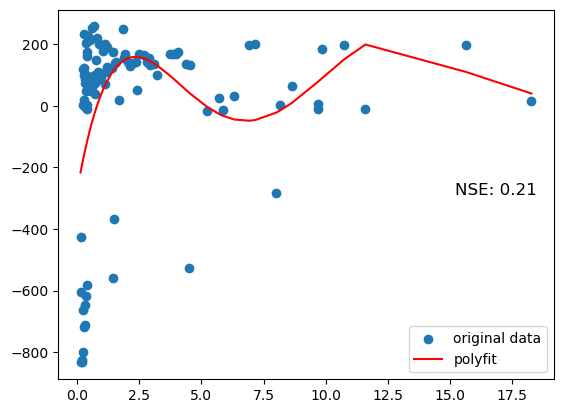

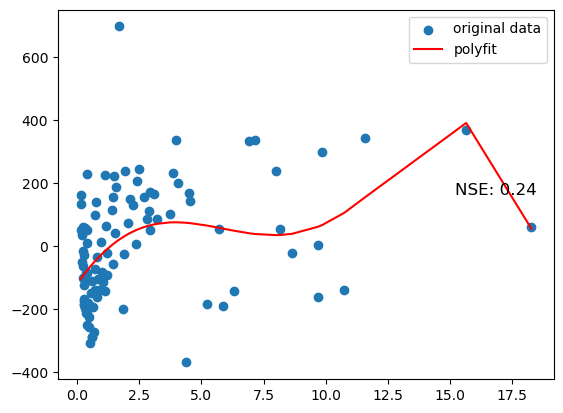

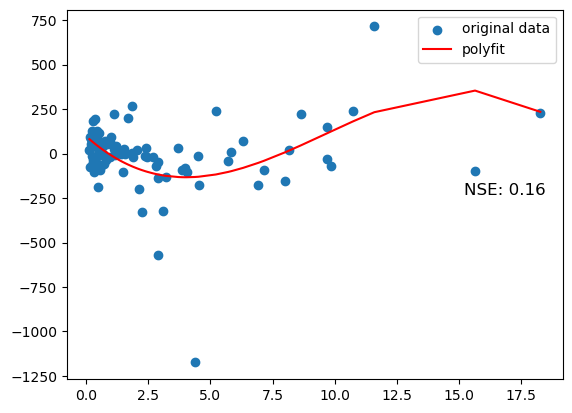

In [19]:
### --- CHOOSE THE MAX DEGREE OF THE POLYNOMIALS TO EVALUATE --- ###
num_deg = 5

### --- CHOOSE THE NSE CUT-OFF FOR NSE SCORE OF THE POLYNOMIALS --- ###
NSE_cut = 0.1

# Call the function to evaluate the polynomials
modes_poly, degs, polys = best_polynomial_fits(reof_ds, num_deg, NSE_cut)

print(modes_poly)

if modes_poly == []:
    print(f'No polynomial fits were found with NSE >= {NSE_cut}')
else:
    print(f'Polynomial fits found for modes: {modes_poly}, degrees: {degs}')

In [20]:
for i in range(0,len(modes_poly)):
    print(f'modes:\n {modes_poly[i]}')
    print(f'degree:\n {degs[i]}')
    print(f'polynomials:\n {polys[i]}')

modes:
 1
degree:
 5
polynomials:
            5          4         3       2
-0.006682 x + 0.7855 x - 19.85 x + 161 x - 261.1 x - 156.6
modes:
 4
degree:
 5
polynomials:
          5         4         3         2
0.02566 x - 1.271 x + 22.31 x - 164.3 x + 463.3 x - 275
modes:
 9
degree:
 5
polynomials:
            5          4           3         2
-0.005972 x + 0.1478 x - 0.05437 x - 17.51 x + 111.6 x - 118.3
modes:
 10
degree:
 3
polynomials:
          3         2
-0.6824 x + 19.76 x - 125.8 x + 97.63


Building models for mode-01
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,232 (391.54 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 66,820 (261.02 KB)

1 0.47208023663977805


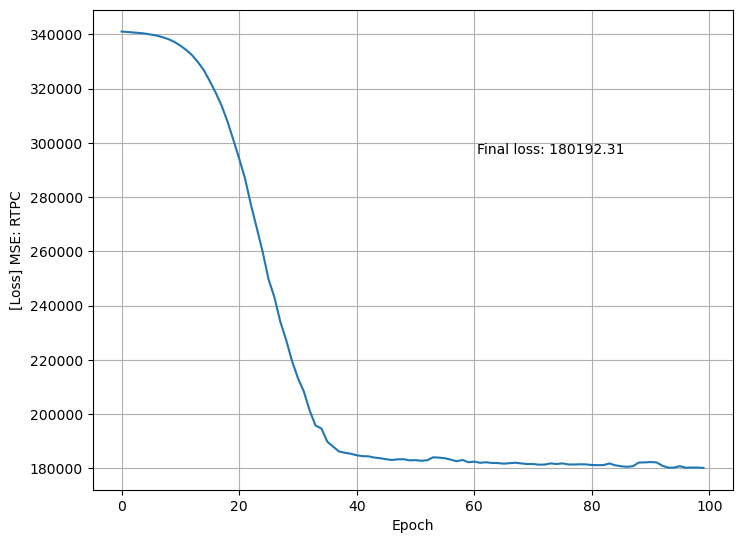

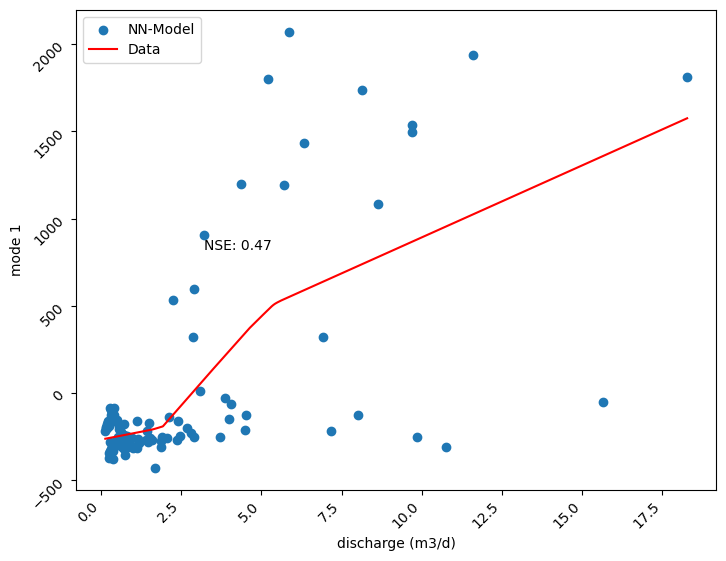

Building models for mode-02
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-03
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-04
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-05
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-06
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-07
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-08
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Building models for mode-09
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,232 (391.54 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 66,820 (261.02 KB)

9 0.265754702202728


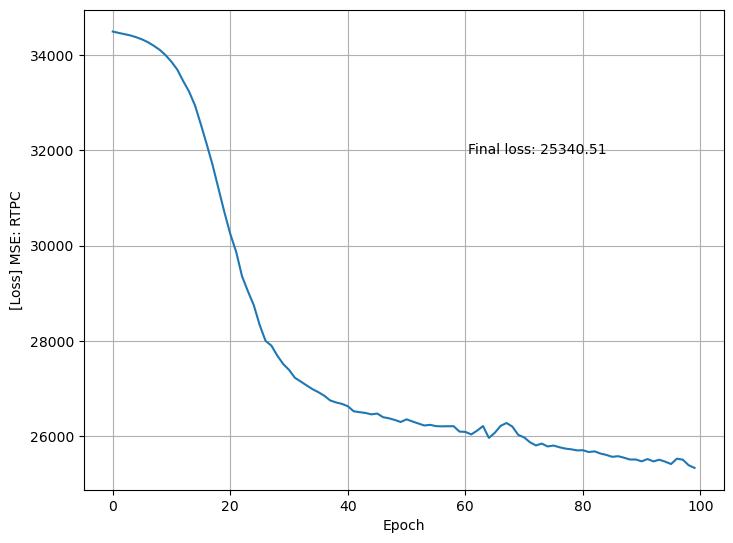

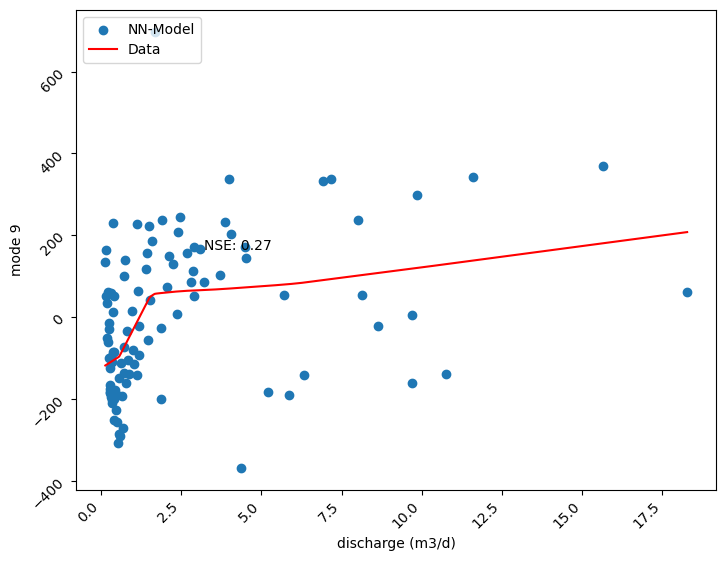

Building models for mode-10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
NN fits found for modes: [1, 9]


In [21]:
# Call the function to evaluate the neural network fits
models_nn, modes_nn = nn_fit(reof_ds, q, NSE_cut)

if models_nn == []:
    print(f'No NN fits were found with NSE = {NSE_cut}')
else:
    print(f'NN fits found for modes: {modes_nn}')

# Forecasts

***
## Select forecast type

* Best mode only.
    * This method uses only the best mode as determined from the cells above.
    * This method is likely best when passing SAR imagery to the REOF. In this situation, we expect only one or two modes to reflect water extent. 
* Mode summation.
    * This method sums the contribution of all modes up to a user selected count.
    * This method is best when passsing water masks to the REOF. When using water masks, every mode should reflect a different process related to flooding. 

In [ ]:
# [I AM HERE; insert code to select forecast type: best single mode, best modes, user selected modes]

# 

***
## Run the forecast

In [22]:
### --- Prepare Discharge dataset --- ###

# Find the index of the first day of the forecast
ind_start = np.where(q_tot.time == q.time[-1])[0][0]

# Find the index of the last day of the forecast
ind_stop = np.where(q_tot.time == da_tot.time[ind_flood])[0][0]

# Crop the discharge to the same range as the forecast
q_forecast = q_tot.isel(time=slice(ind_start, ind_stop + 1))



In [23]:
# define function to create the forecast for a single mode

def mySingleModeForecaster(forecastType, allModes, myMode, q_forecast, reof_ds, models, type_file): 
    # Create the forecast based on a single spatial mode

    # Get dimensions of datasets
    n_modes, y, x = reof_ds.spatial_modes.shape
    t = q_forecast.shape[0]

    # Create the variable filled with zeros
    zeros_variable = np.zeros((t, y, x))

    ### --- Initialize some important arrays --- ###
    
    # Create the new DataArray with zeros_variable
    da = xr.DataArray(
        zeros_variable,
        coords={'time': q_forecast.time, 'y': reof_ds.y, 'x': reof_ds.x},
        dims=['time', 'y', 'x']
    )

    # Make predictions using the best model(s)
    if 'p' in forecastType:
        print('poly ran')
        forecast_rtcp = np.array([model(q_forecast.values) for model in models]).squeeze()
    elif 'n' in forecastType:
        print('neural ran')
        forecast_rtcp = np.array([model.predict(q_forecast.values) for model in models]).squeeze() # original
    else:
        print('Input forecastType is neither neural network nor polynomial!')

    # Check the size of the forecasted rtcps. If it has only one dimension, add a new dimension
    if len(forecast_rtcp.shape) == 1:
        print('this ran')
        forecast_rtcp = forecast_rtcp[:, np.newaxis] # Add a new dimension
        forecast_rtcp = forecast_rtcp.T # Transpose to match the dimensions of the spatial modes

    ### --- Reconstruct the dataset by multiplying the spatial mode by the forecast for each significant mode --- ###
    
    idxM = allModes.index(myMode)
    print(f'myMode = {myMode}')
    print(f'idxM = {idxM}')
    print(f'allModes[idxM] = {allModes[idxM]}')
    forecast_nocenter = np.dot(reof_ds.spatial_modes.sel(mode=allModes[idxM]).values.reshape(-1,1), forecast_rtcp[idxM].reshape(1,len(forecast_rtcp[idxM]))).reshape(y,x,t).transpose(2,0,1)
    for i in range(0,forecast_nocenter.shape[0]):
        forecast_nocenter[i,:,:] = np.flipud(forecast_nocenter[i,:,:])
    

    # Add to the reconstructed dataset
    da.values += forecast_nocenter + reof_ds.center.values

    # If water mask, REOF gives FLOAT we have to round to 0 or 1
    if type_file == 'Water_Masks':
        da.values = np.round(da.values)

    return da

In [24]:
modes_nn

[1, 9]

In [25]:
modes_poly

[1, 4, 9, 10]

In [26]:
### --- Run forecast on a single mode --- ###
myMode = 1
da_nn = mySingleModeForecaster('neural network',modes_nn, myMode, q_forecast, reof_ds, models_nn, type_file)
da_poly = mySingleModeForecaster('polynomial', modes_poly, myMode, q_forecast, reof_ds, polys, type_file)

neural ran
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
myMode = 1
idxM = 0
allModes[idxM] = 1
poly ran
myMode = 1
idxM = 0
allModes[idxM] = 1


In [215]:
### --- Run forecast on all of the best modes and sum them --- ###

# Get dimensions of datasets
n_modes, y, x = reof_ds.spatial_modes.shape
t = q_forecast.shape[0]

# Create the variable filled with zeros
zeros_variable = np.zeros((t, y, x))

### --- Initialize some important arrays --- ###

# Create the new DataArray with zeros_variable
da_nn_aggregate = xr.DataArray(
    zeros_variable,
    coords={'time': q_forecast.time, 'y': reof_ds.y, 'x': reof_ds.x},
    dims=['time', 'y', 'x']
)
da_poly_aggregate = xr.DataArray(
    zeros_variable,
    coords={'time': q_forecast.time, 'y': reof_ds.y, 'x': reof_ds.x},
    dims=['time', 'y', 'x']
)

type_file_sum = 'none' # making it anything other than 'Water_Masks' prevents the rounding from running, which we need to do after we've summed everything up. 

# Run forecast for the neural network
for mode in modes_nn:
    da_nn_loop = mySingleModeForecaster('neural network',modes_nn, mode, q_forecast, reof_ds, models_nn, type_file_sum) # calculate the forecast for an individual mode
    da_nn_aggregate.values += da_nn_aggregate.values + da_nn_loop.values # collect all of the forecasts
da_nn_aggregate.values = da_nn_aggregate.values / (len(modes_nn) + 1.0) # normalize the forecasts
da_nn_aggregate.values = np.round(da_nn_aggregate.values) # round the values since it's either water (>0.5) or it isnt' (<0.5)

# Run forecast for the polynomials
# I AM HERE; polynomial forecast is not working correctly; I think I'm passing the mode number wrong. Or my function doesn't actually call the modes in the way I think it does. 
for mode in modes_poly:     
    da_poly_loop = mySingleModeForecaster('polynomial', modes_poly, mode, q_forecast, reof_ds, polys, type_file_sum)
    da_poly_aggregate.values += da_poly_aggregate.values + da_poly_loop.values
da_poly_aggregate.values = da_poly_aggregate.values / (len(modes_poly) + 1.0)
da_poly_aggregate.values = np.round(da_poly_aggregate.values)

neural ran
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
myMode = 1
idxM = 0
allModes[idxM] = 1
neural ran
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
myMode = 4
idxM = 1
allModes[idxM] = 4
neural ran
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
myMode = 9
idxM = 2
allModes[idxM] = 9
poly ran
myMode = 1
idxM = 0
allModes[idxM] = 1
poly ran
myMode = 4
idxM = 1
allModes[idxM] = 4
poly ran
myMode = 9
idxM = 2
allModes[idxM] = 9
poly ran
myMode = 10
idxM = 3
allModes[idxM] = 10


In [219]:
unique_elements, counts = np.unique(da_poly_aggregate[-1,:,:], return_counts=True)
print(unique_elements)
print(counts)

[-1.000e+00  0.000e+00  1.000e+00  2.000e+00  3.000e+00  4.000e+00
  5.000e+00  6.000e+00  7.000e+00  8.000e+00  9.000e+00  1.000e+01
  1.100e+01  1.200e+01  1.300e+01  1.400e+01  1.500e+01  1.600e+01
  1.700e+01  1.800e+01  1.900e+01  2.000e+01  2.100e+01  2.200e+01
  2.300e+01  2.400e+01  2.500e+01  2.600e+01  6.477e+03]
[    148  843098    4562   44097   97411   51030   92296   65696   72094
   68694   65905   64334   55806   77366   75389   62910   34460   29685
   30356   31823   27151   26381   29525   37389   48746   77133  211260
   63718 2327846]


***
## Accuracy of forecasts

Compare the forecast results to actual flood extent or SAR imagery. 

NN Overall accuracy: 44.26%
NN Critical Success Index: 76.61%
NN Precision: 87.95%
NN Recall: 85.59%
Polynomial Overall accuracy: 48.62%
Polynomial Critical Success Index: 76.66%
Polynomial Precision: 83.99%
Polynomial Recall: 89.78%


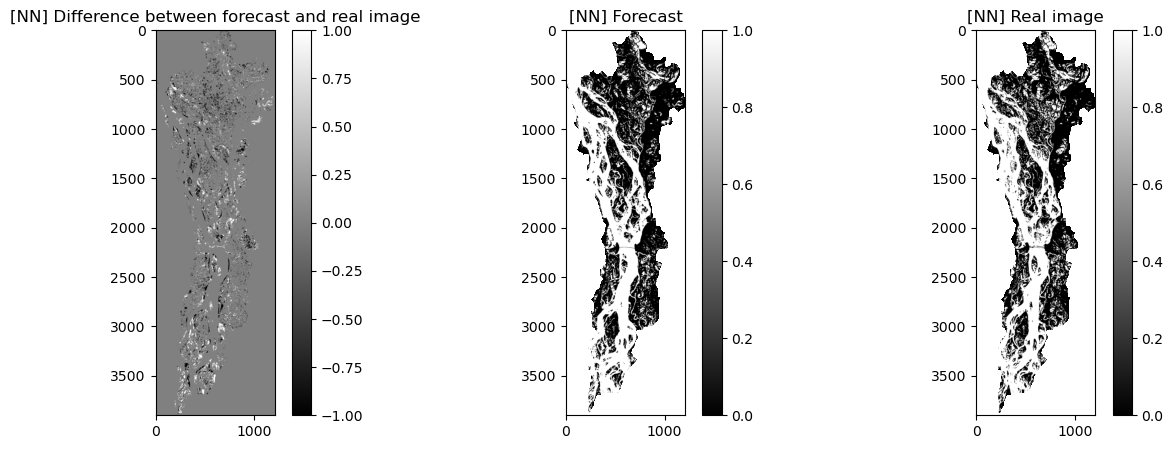

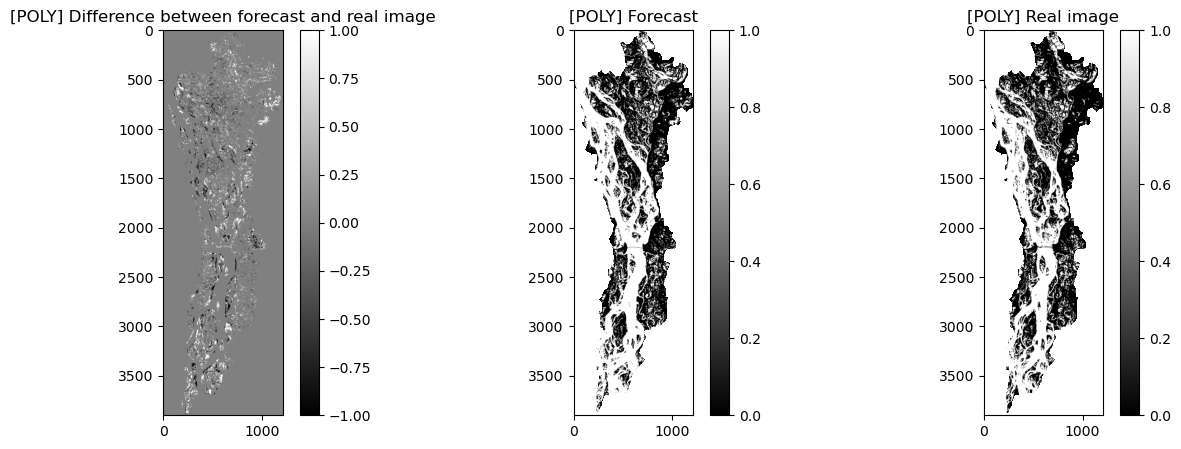

In [27]:
myCmap = 'gray'

### --- Calculate the scores of the forecasts --- ###
if modes_nn != []:
    overall_accuracy, CSI, precision, recall = z_score(da_nn.values[-1], da_tot.values[ind_flood])
    print(f"NN Overall accuracy: {overall_accuracy:.2f}%")
    print(f"NN Critical Success Index: {CSI:.2f}%")
    print(f"NN Precision: {precision:.2f}%")
    print(f"NN Recall: {recall:.2f}%")

    ### --- Plot the forecasts --- ###

    ## Neural Net
    # Plot the forecast - the real image
    fig_nn_results, ax_nn_results = plt.subplots(1,3,figsize=(15,5))
    im = ax_nn_results[0].imshow(da_nn.values[-1] - da_tot.values[ind_flood], vmin=-1, vmax=1, cmap=myCmap)
    plt.colorbar(im, ax=ax_nn_results[0])
    ax_nn_results[0].set_title('[NN] Difference between forecast and real image')

    # Plot the forecast
    im = ax_nn_results[1].imshow(da_nn.values[-1], vmin = 0, vmax = 1, cmap=myCmap)
    plt.colorbar(im, ax=ax_nn_results[1])
    ax_nn_results[1].set_title('[NN] Forecast')

    # Plot the real image
    im = ax_nn_results[2].imshow(da_tot.values[ind_flood], vmin = 0, vmax = 1, cmap=myCmap)
    plt.colorbar(im, ax=ax_nn_results[2])
    ax_nn_results[2].set_title('[NN] Real image')

    

if modes_poly != []:
    overall_accuracy, CSI, precision, recall = z_score(da_poly.values[-1], da_tot.values[ind_flood])
    print(f"Polynomial Overall accuracy: {overall_accuracy:.2f}%")
    print(f"Polynomial Critical Success Index: {CSI:.2f}%")
    print(f"Polynomial Precision: {precision:.2f}%")
    print(f"Polynomial Recall: {recall:.2f}%")

    ### --- Plot the forecasts --- ###

    # Plot the forecast - the real image
    fig_poly_results, ax_poly_results = plt.subplots(1,3,figsize=(15,5))
    im = ax_poly_results[0].imshow(np.round(da_poly.values[-1] - da_tot.values[ind_flood]), vmin=-1, vmax=1, cmap=myCmap)
    plt.colorbar(im, ax=ax_poly_results[0])
    ax_poly_results[0].set_title('[POLY] Difference between forecast and real image')


    # Plot the forecast
    im = ax_poly_results[1].imshow(np.round(da_poly.values[-1]), vmin = 0, vmax = 1, cmap=myCmap)
    plt.colorbar(im, ax = ax_poly_results[1])
    ax_poly_results[1].set_title('[POLY] Forecast')

    # Plot the real image
    im = ax_poly_results[2].imshow(np.round(da_tot.values[ind_flood]), vmin = 0, vmax = 1, cmap=myCmap)
    plt.colorbar(im, ax=ax_poly_results[2])
    ax_poly_results[2].set_title('[POLY] Real image')

***
### Plot of flood forecasts, flood percentages through time, and discharge through time

In [28]:
# define function to plot flood forecasts
def create_subplots(myArray,figsize):

    ncols, nrows = 7,2
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()

    n_plots = myArray.shape[0]

    for i in range(0,n_plots):
        
        axs[i].imshow(myArray[i,:,:], cmap='gray', vmin=0.0, vmax=1.0)
        axs[i].title.set_text(f'{myArray[i].time.dt.strftime("%Y-%m-%d").values}')

    return

In [29]:
# define function to get flood percentages from each flood forecast. 

def floodPercentCalc(forecast): 
    # set up empty array into which to put the percentages
    floodPercent=np.array([])
    # set up the total number of forecasts and a counter to keep track of progress. 
    total = forecast.shape[0]
    county = 0
    print("Starting calcualtion")
    for cast in forecast:
        # get the unique elements and their counts
        unique_elements, counts = np.unique(cast, return_counts=True)
        myDict = dict(zip(unique_elements, counts))
        myArea = myDict[0] + myDict[1]
        flooded = myDict[1]
        floodPercent = np.append(floodPercent, flooded/myArea*100.0)
        county += 1
        print(f"{county} of {total} complete")
    return floodPercent

In [30]:
# define function to plot flood percentage and discharge through time

def plot_flood_and_discharge(forecasts,flood_percents,q_tot, floodpercent_real = [], time_real= []):
    
    # set up figure and twin the axis
    fig_perc_dis, ax1 = plt.subplots(figsize=(9,6))
    ax2 = ax1.twinx()
    
    # plot the neural network flood percentages
    ln1 = ax1.plot(forecasts.time, flood_percents, color='blue', marker='o', label='Predicted Flood Percentage')
    ax1.set_ylabel('Flood Percentage [%]')
    ax1.grid()
    
    # plot the discharge values through same time. 
    idx1, idx2 = np.where(forecasts[0].time == q_tot.time)[0][0], np.where(forecasts[-1].time == q_tot.time)[0][0]
    ln2 = ax2.plot(q_tot[idx1:idx2+1].time, q_tot[idx1:idx2+1], color='red', marker='^', label='Discharge')
    ax2.set_ylabel('Discharge [$m^3/s$]')

    if floodpercent_real.any():
        print('I ran!')
        # I AM HERE
        # find index for relevant times
        # idxA, idxB = np.where(time_real
    
        # add points of relevant times to ax1
    
    # create legend entries
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs)
    
    plt.show()

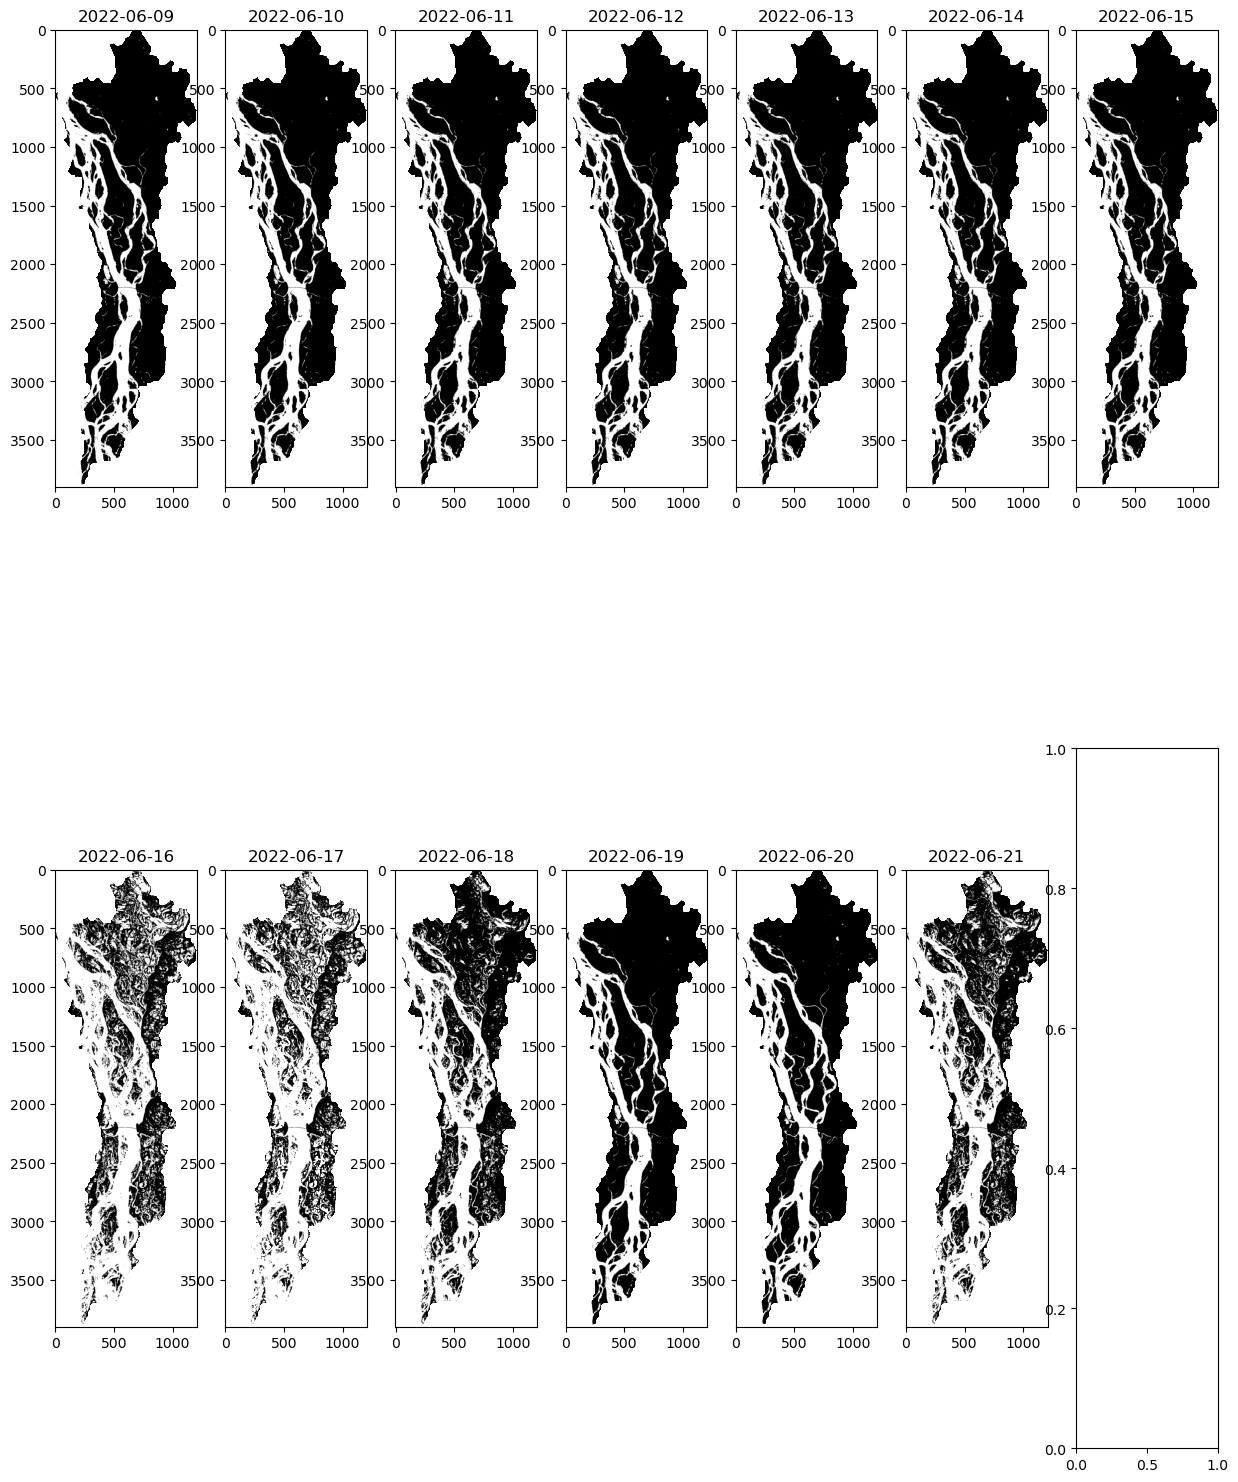

In [31]:
# plot each forecast day for neural network
create_subplots(da_nn,(15,20))

In [33]:
flood_percent_nn = floodPercentCalc(da_nn)

Starting calcualtion
1 of 13 complete
2 of 13 complete
3 of 13 complete
4 of 13 complete
5 of 13 complete
6 of 13 complete
7 of 13 complete
8 of 13 complete
9 of 13 complete
10 of 13 complete
11 of 13 complete
12 of 13 complete
13 of 13 complete


I ran!


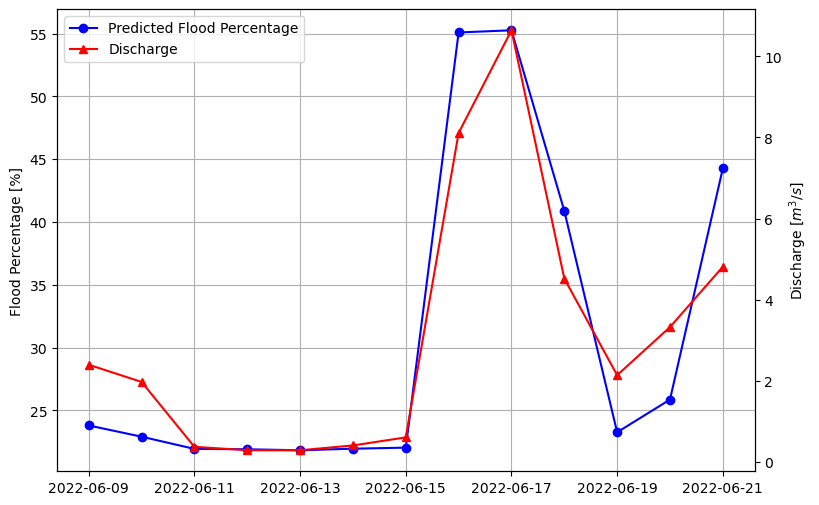

In [34]:
plot_flood_and_discharge(da_nn,flood_percent_nn,q_tot,floodpercent, time_flood)

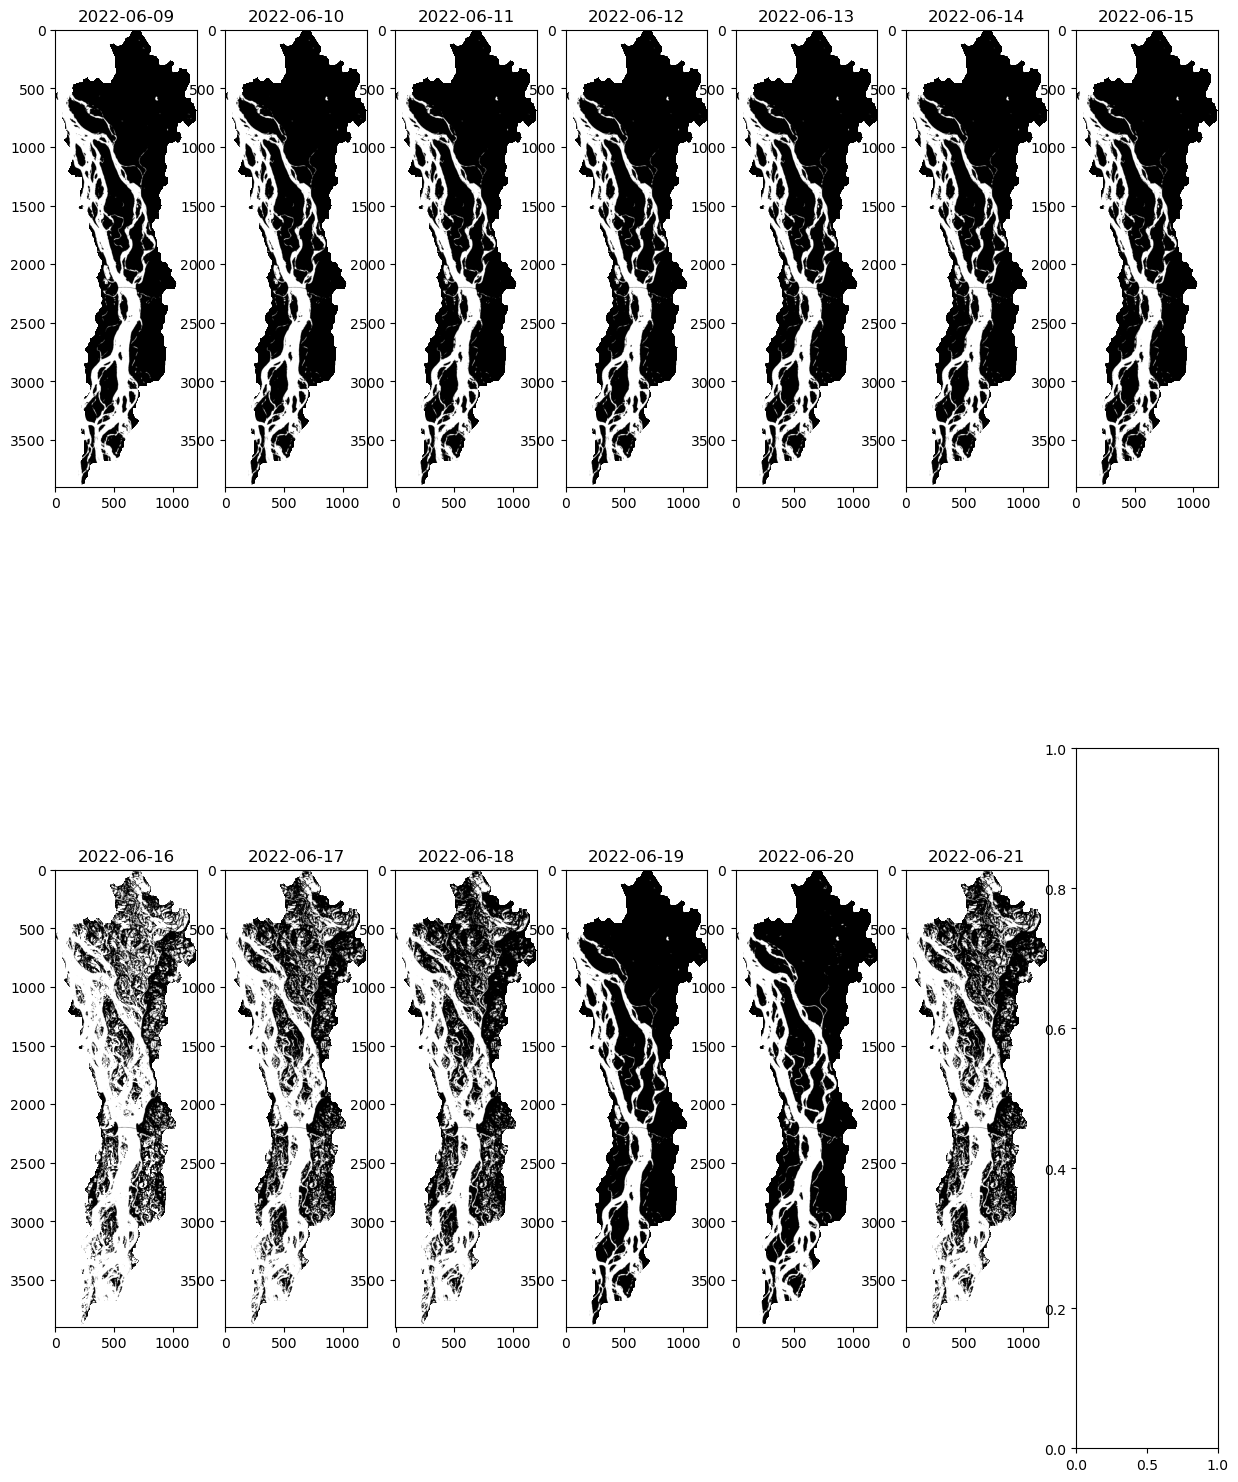

In [35]:
# plot each forecast day for neural network
create_subplots(da_poly,(15,20))

In [36]:
flood_percent_poly = floodPercentCalc(da_poly)

Starting calcualtion
1 of 13 complete
2 of 13 complete
3 of 13 complete
4 of 13 complete
5 of 13 complete
6 of 13 complete
7 of 13 complete
8 of 13 complete
9 of 13 complete
10 of 13 complete
11 of 13 complete
12 of 13 complete
13 of 13 complete


I ran!


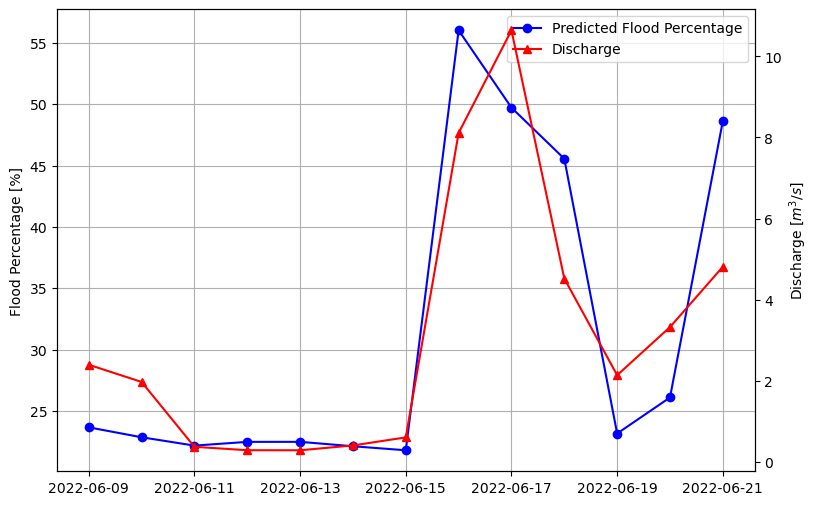

In [37]:
plot_flood_and_discharge(da_poly,flood_percent_poly,q_tot, floodpercent, time_flood)

***
## Save the data files of interest for later loading. 

TO SAVE
* plotted forecasts
* polynomials
* NN
* REOF modes (temporal and spatial)

In [38]:
# I AM HERE; need to improve this; what if they don't have water masks? 
# Load one of the SAR images or water masks in order to get the coordinate reference system. This is used in saving the forecasts as geotiffs. 
folder = fc.selected+'Water_Masks/'
prefix = '*combined'

# Gather names of files corresponding to the file type and polarization we want
tiff_dir = Path(folder)
tiffs = list(tiff_dir.glob(f'{prefix}.tif*'))

raster = rasterio.open(tiffs[0])

raster.crs

CRS.from_epsg(32646)

In [45]:
# Write function to save the forecasts as geotiffs. 
def saveForecasts(saveFolder, da, raster, parent):
    # Make directory if needed
    Path(parent, saveFolder).mkdir(parents=True, exist_ok=True)
    
    county = 1
    for tiff in da:
        # flip the data; it looks upside here, but it saves and displays incorrectly in ArcGIS without it
        # myValues = np.abs(np.flipud(tiff.values))
        myValues = np.abs(tiff.values) # need to take the absolute value as there are some "negative" zero values (I know, negative zero isn't actually a thing; the computer sure thinks it is)
        # create save file name
        file2save = Path(parent,saveFolder,f'Day-{county:02d}_{str(tiff.time.dt.strftime("%Y-%m-%d").values)}.tif')
        print(file2save)
        # open raster file and save
        with rasterio.open(
            file2save,
            mode="w",
            driver="GTiff",
            height=tiff.shape[0],
            width=tiff.shape[1],
            count=1,
            dtype=tiff.dtype,
            crs=raster.crs,
            transform=raster.transform,
        ) as new_dataset:
            new_dataset.write(myValues, 1)
        county += 1
    

In [46]:
# Works! 
save_folder = 'forecasts_poly_v3'
saveForecasts(save_folder, da_poly, raster, fc.selected)
save_folder = 'forecasts_nn_v4'
saveForecasts(save_folder, da_poly, raster, fc.selected)

/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-01_2022-06-09.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-02_2022-06-10.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-03_2022-06-11.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-04_2022-06-12.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-05_2022-06-13.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-06_2022-06-14.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-07_2022-06-15.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-08_2022-06-16.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-09_2022-06-17.tif
/home/jovyan/hydrosar/Dataset/bang_NE/subset_bangladesh-West/forecasts_poly_v3/Day-10_2022-